# Script 1: Importing, cleaning and splitting data

#### Final Project in Data Mining, Machine Learning, and Deep Learning|
#### Erik Konstenius, Theodore Balas and Muhammad Azkaenza

## Dependencies

In [6]:
#!pip install numpy pandas plotly matplotlib missingno sklearn keras tensorflow==2.8.0 gdown shutil os

## Import Packages

In [2]:
# Library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import missingno as msno
import os, gdown, shutil
import copy

from tqdm import tqdm
from more_itertools import chunked
from keras.preprocessing import image # load_img in image is using tensorflow 2.8.0

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#### Requirement: 64 GB RAM is needed to process image dataset
## Download and Load raw tabular dataset
The dataset was web-scraped from saatchiart.com with Octoparse software. We retrieved 136043 records with 7 columns of painting details. Then, we downloaded all the images of painting from the link that we obtained in the web-scraping process using VBA. The raw data consists of images and descriptions are stored in a google drive repository.

### Get the dataset:
##### Download manually:
- Download the dataset (images and master.xlsx) from google drive with this link:                                    
https://drive.google.com/drive/folders/1-76Gq_GDkrKm21L2YYANiCtGDnm0Rroe?usp=sharing
- Save them in the same folder as this jupyter notebook file
- Unzip all_images.zip, consists of 120985 images (approx. 2.88 GB)
##### OR use code as below:

In [96]:
# download files from google drive folder with gdown (runtime: > 30 minutes)

url = "https://drive.google.com/drive/folders/1-76Gq_GDkrKm21L2YYANiCtGDnm0Rroe?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

In [3]:
file_path = 'master.xlsx'
raw_data = pd.read_excel(file_path)

In [4]:
raw_data.head()

,image,title,dimensions,painter,origin,price,medium
0,https://images.saatchiart.com/saatchi/555517/a...,Nature 27,60 W x 60 H x 4 D cm,muriel napoli,France,"€1,809",p
1,https://images.saatchiart.com/saatchi/171713/a...,Parallels,50 W x 70 H x 2.5 D cm,Claudio Boczon,Brazil,€459,p
2,https://images.saatchiart.com/saatchi/719498/a...,It's Never Too Late to Save a World,182.9 W x 121.9 H x 5.1 D cm,Jason Wright,United States,"€7,200",p
3,https://images.saatchiart.com/saatchi/974274/a...,Status Quo,42.5 W x 52.7 H x 5.1 D cm,El Lovaas,United States,"€1,530",p
4,https://images.saatchiart.com/saatchi/328164/a...,TV,40 W x 30 H x 1.9 D cm,Kevin Gray,Germany,€765,p


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136043 entries, 0 to 136042
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image       136043 non-null  object
 1   title       136042 non-null  object
 2   dimensions  136043 non-null  object
 3   painter     136043 non-null  object
 4   origin      130285 non-null  object
 5   price       135506 non-null  object
 6   medium      136043 non-null  object
dtypes: object(7)
memory usage: 7.3+ MB


# Preprocess and EDA of tabular data

In [6]:
# copy raw_data to start preprocessing
tabular_data = raw_data.copy()

## Null/NA
There are almost no nulls in the dataset. The web scraper seems to have picked up the data that we are interested in. The column with the most amount of nulls is the one with the origination of each painter.

In total, there are 6296 null values in 3 columns. We decided to drop all rows with null/na and reset the index. 

The dataset reduced into 129809 rows (95.42% of raw data).

In [7]:
print("Number of paintings in dataset: " + str(raw_data.shape[0]))
print("Number of nulls in dataset: " + str(raw_data.isna().sum().sum()))

Number of paintings in dataset: 136043
Number of nulls in dataset: 6296


In [8]:
# check number of nulls
tabular_data.isna().sum()

image            0
title            1
dimensions       0
painter          0
origin        5758
price          537
medium           0
dtype: int64

Text(0.5, 1.0, 'Number of nulls per column')

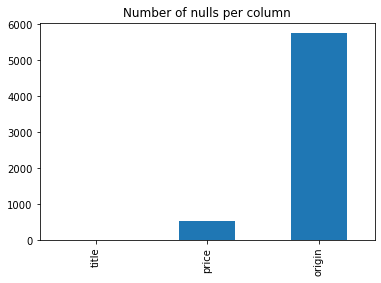

In [9]:
tabular_data.isna().sum()[tabular_data.isna().sum()>0].sort_values().plot(kind='bar')
plt.title("Number of nulls per column")

In [53]:
# visualize distribution of nulls in dataset. Useful to investigate the consistency in web scraper
msno.matrix(tabular_data)
gray_patch = mpatches.Patch(color='gray', label='Non-null')
white_patch = mpatches.Patch(color='white', label='Null')
plt.legend(handles=[gray_patch, white_patch])
plt.title(label = "Distribution of nulls")

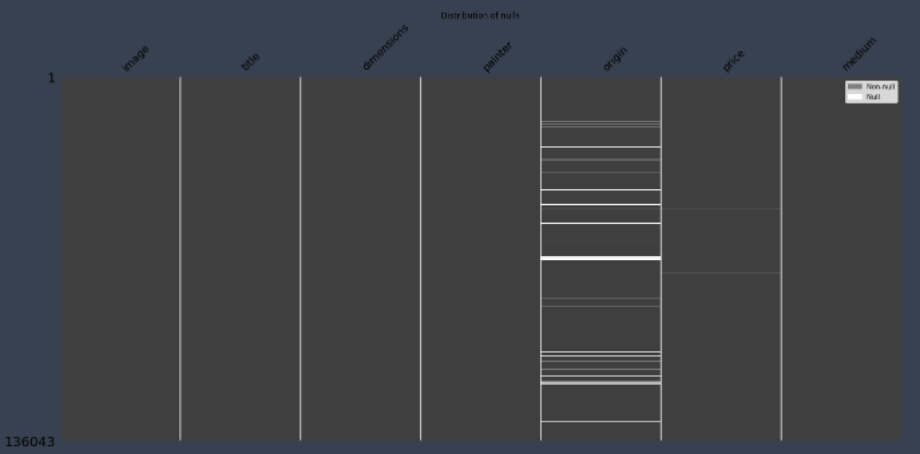

In [11]:
# remove null and reset index

tabular_data = tabular_data.dropna().reset_index(drop = True)
tabular_data.shape

(129809, 7)

## "image" column
Remove duplicates in 'image' column, get image name from image link, and only include certain length of image name ( >20 characters) in the dataset. 

And since the image dataset only has image name, image name will be used as unique ID in pairing the tabular data to its respective image.

The dataset is reduced to 129585 rows (95.25% raw).

In [12]:
# extract image file name from link

# splits the string where "/" exists and extracts its last component (the title)
tabular_data['image'] = tabular_data['image'].apply(lambda x: x.split('/')[-1])

In [13]:
# calculate number of characters in image column to check results
linksdf = tabular_data['image']
linksdf.map(len)
linksdf.apply(len).value_counts()

22    126965
21      2620
13       126
12        44
20        27
11        25
19         2
Name: image, dtype: int64

In [14]:
# given that only links with a length of 21 or 22 are valid, the rest are dropped
tabular_data = tabular_data[tabular_data['image'].map(len) > 20]

# resetting indeces to avoid key error
tabular_data.reset_index(drop = True, inplace = True)

# recalculate number of characters in image column to validate results
linksdf = tabular_data['image']
linksdf.map(len)
linksdf.apply(len).value_counts()

22    126965
21      2620
Name: image, dtype: int64

## "dimensions" column

In [15]:
# extract width and height from "dimensions" column
tabular_data['width'] = tabular_data['dimensions'].apply(lambda x: x.split(' ')[0]).astype(float)
tabular_data['height'] = tabular_data['dimensions'].apply(lambda x: x.split(' ')[3]).astype(float)

# calculate area column
tabular_data['area'] = tabular_data['width'] * tabular_data['height']

## "price" column
Remove non-numeric characters and convert data type into integer. 

In [16]:
# convert "price" column to integer
tabular_data['price'] = tabular_data['price'].replace('\D+','', regex=True).astype(int)

In [54]:
fig = px.histogram(tabular_data, x="price", nbins=100)
fig.show()

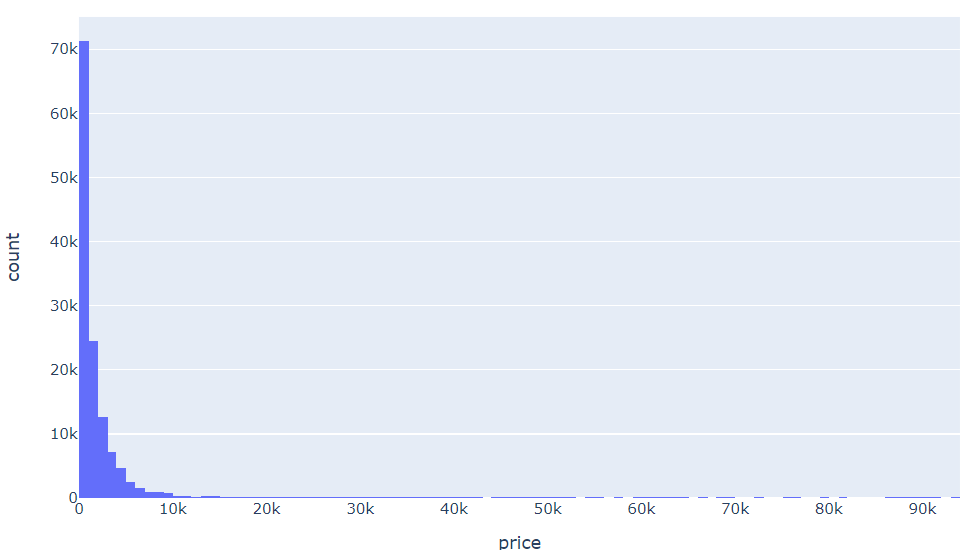

In [55]:
fig = px.box(tabular_data, y="price")
fig.show()

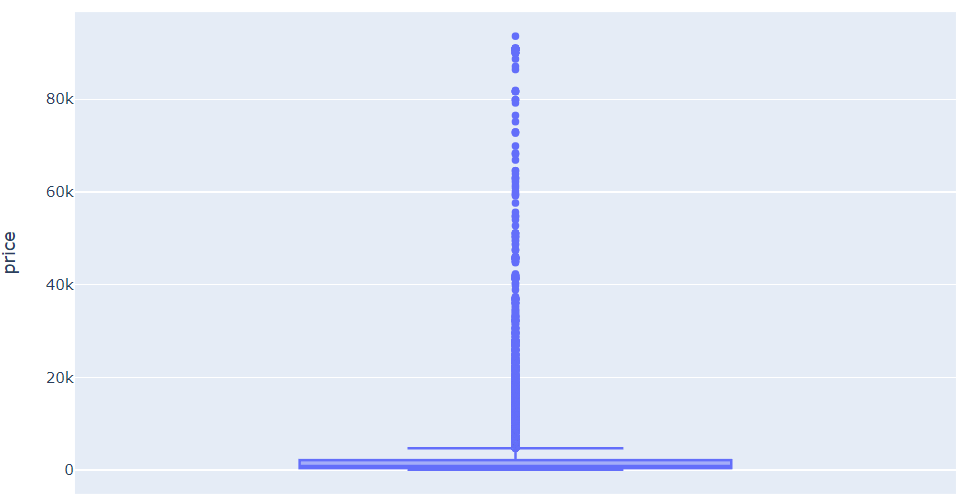

In [19]:
print("Share of art pieces with a price of 9000 euro: " + str(round(tabular_data.loc[tabular_data['price'] > 9000,'price'].count()/tabular_data['price'].count(),4)))

Share of art pieces with a price of 9000 euro: 0.0231


In [56]:
# height distribution after removing some outliers
fig = px.box(tabular_data, x="height")
fig.show()

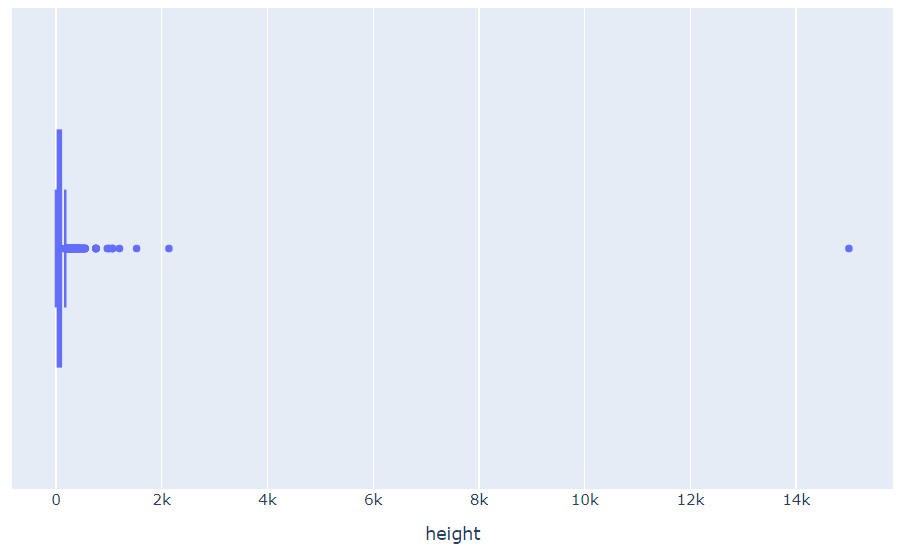

In [57]:
# height distribution after removing some outliers
fig = px.box(tabular_data, x="width")
fig.show()

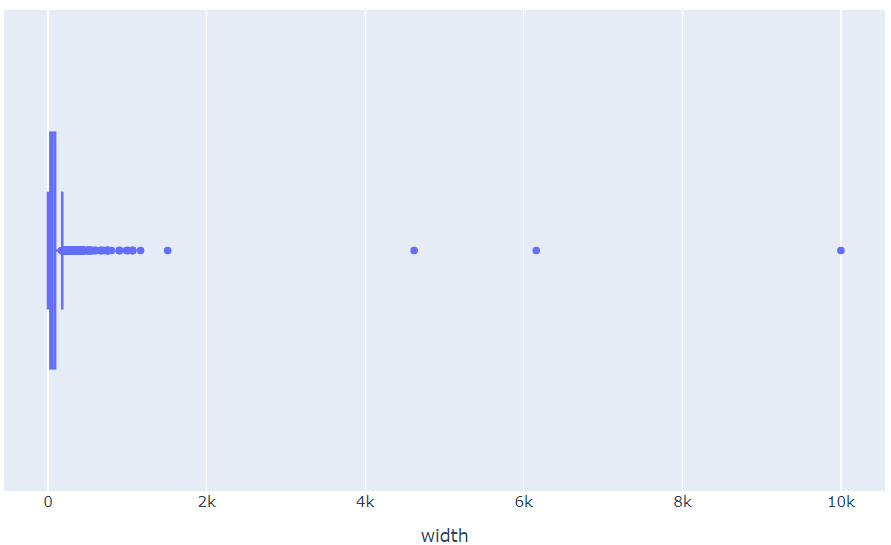

## Remove outliers
Most art pieces cost under 2052 EUR. The median of art pieces in the dataset is priced at 855 EUR. There are a couple of clear outliers in the dataset. We will classify painting with a price of over 9000 EUR as outliers or as "fine art". We do not wish to create a model that has been trained on fine art and thus we will remove them. And we also removed all paintings with dimension bigger than 200 cm in one of its side.

The dataset shrank to 125279 rows (92.09% of raw data).

In [22]:
# remove outliers (height, width and price)

# remove paintings with price more than 9.000
tabular_data = tabular_data.drop(tabular_data[tabular_data.price > 9000].index).reset_index(drop = True)

# drop all paintings with a height and width of over 200 cm
tabular_data = tabular_data.drop(tabular_data[tabular_data.height > 200].index)
tabular_data = tabular_data.drop(tabular_data[tabular_data.width > 200].index)
# around 1% of the images

In [23]:
print('Total rows in dataset after removing outliers: '+ str(tabular_data.shape[0]))

Total rows in dataset after removing outliers: 125279


In [58]:
# price distribution after removing some outliers
fig = px.histogram(tabular_data, x="price", nbins=20)
fig.show()

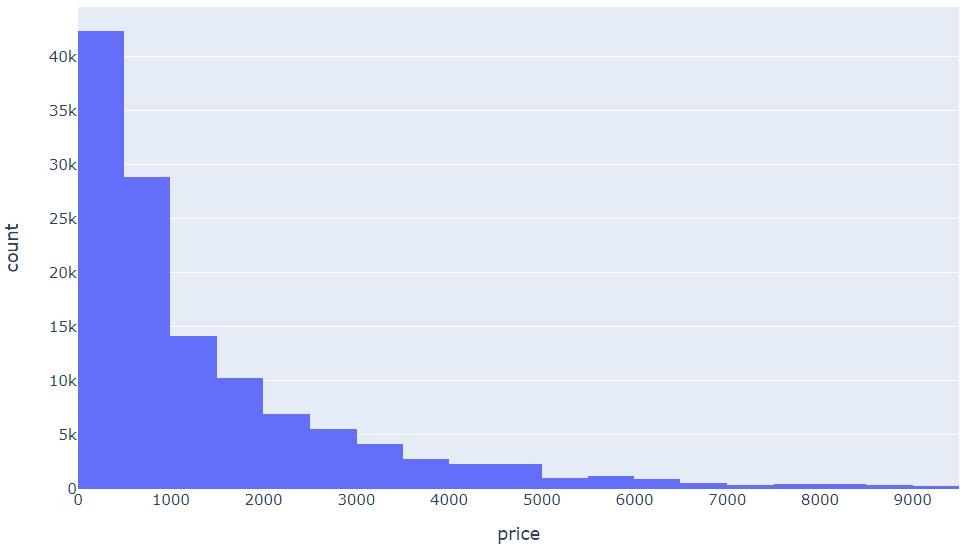

In [59]:
# price distribution after removing some outliers
fig = px.box(tabular_data, y="price")
fig.show()

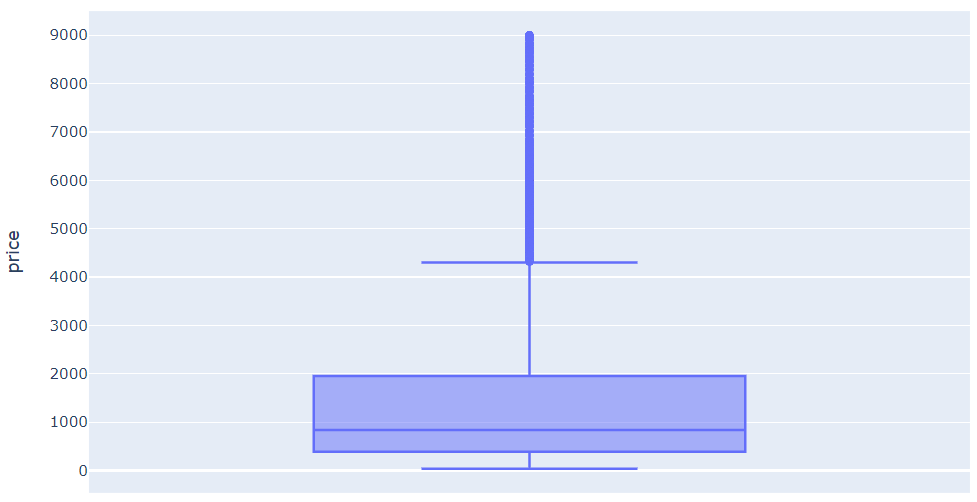

In [60]:
# height distribution after removing some outliers
fig = px.box(tabular_data, x="height")
fig.show()

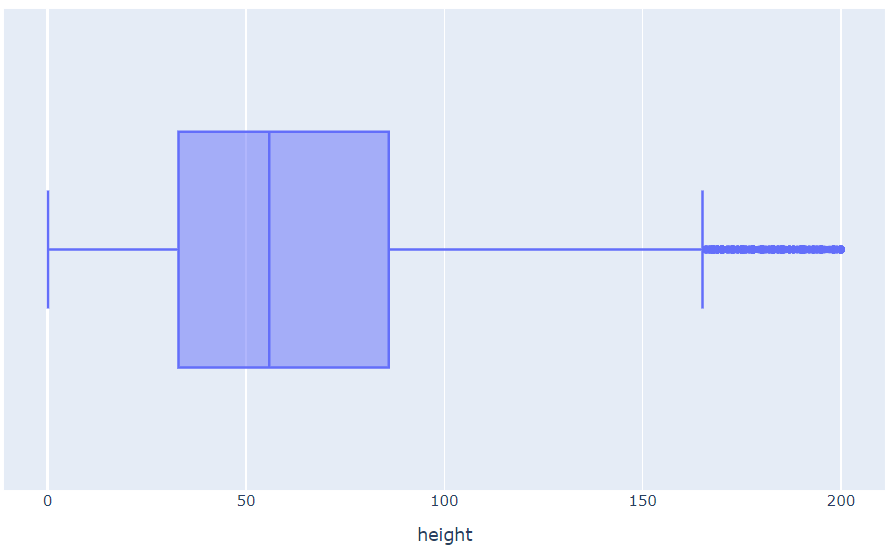

In [61]:
# width distribution after removing some outliers
fig = px.box(tabular_data, x="width")
fig.show()

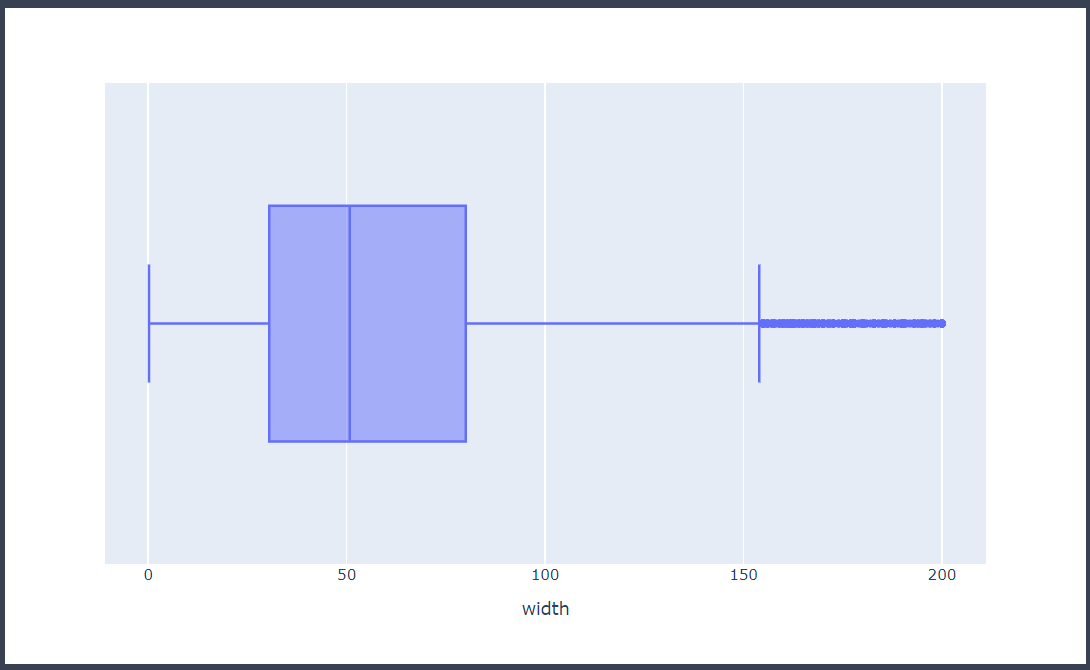

## Further EDA

In [28]:
tabular_data_copy = copy.deepcopy(tabular_data)

tabular_data_copy['medium'] = tabular_data_copy['medium'].replace(['a'], 'Acrylic')
tabular_data_copy['medium'] = tabular_data_copy['medium'].replace(['g'], 'Guache')
tabular_data_copy['medium'] = tabular_data_copy['medium'].replace(['i'], 'Ink')
tabular_data_copy['medium'] = tabular_data_copy['medium'].replace(['o'], 'Oil')
tabular_data_copy['medium'] = tabular_data_copy['medium'].replace(['p'], 'Pastel')
tabular_data_copy['medium'] = tabular_data_copy['medium'].replace(['w'], 'Watercolour')

In [62]:
# average price per medium
fig = px.bar(
    data_frame=tabular_data_copy.groupby(['medium']).mean().reset_index(), 
    x="medium", 
    y="price")
fig.show()

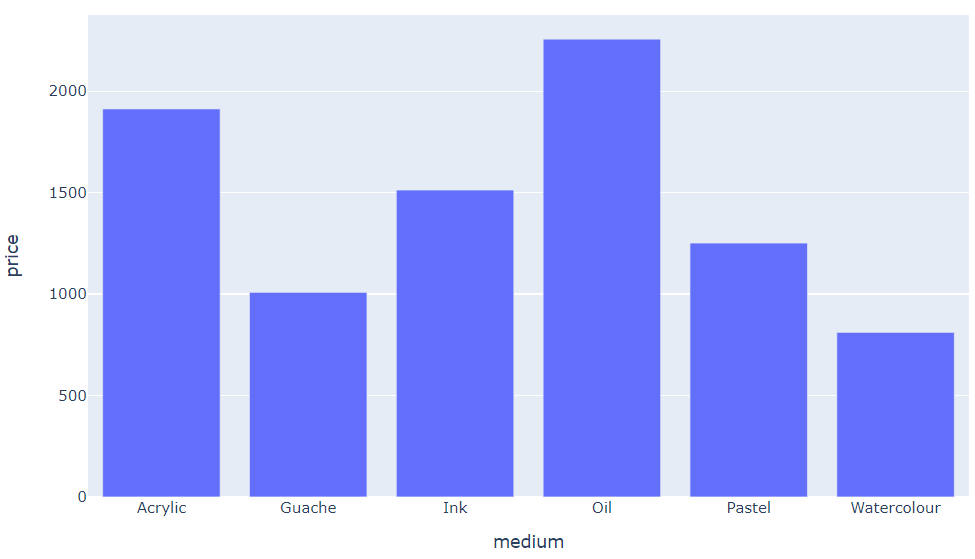

<AxesSubplot:title={'center':'Countries with the cheapest art on average in the dataset'}, xlabel='origin'>

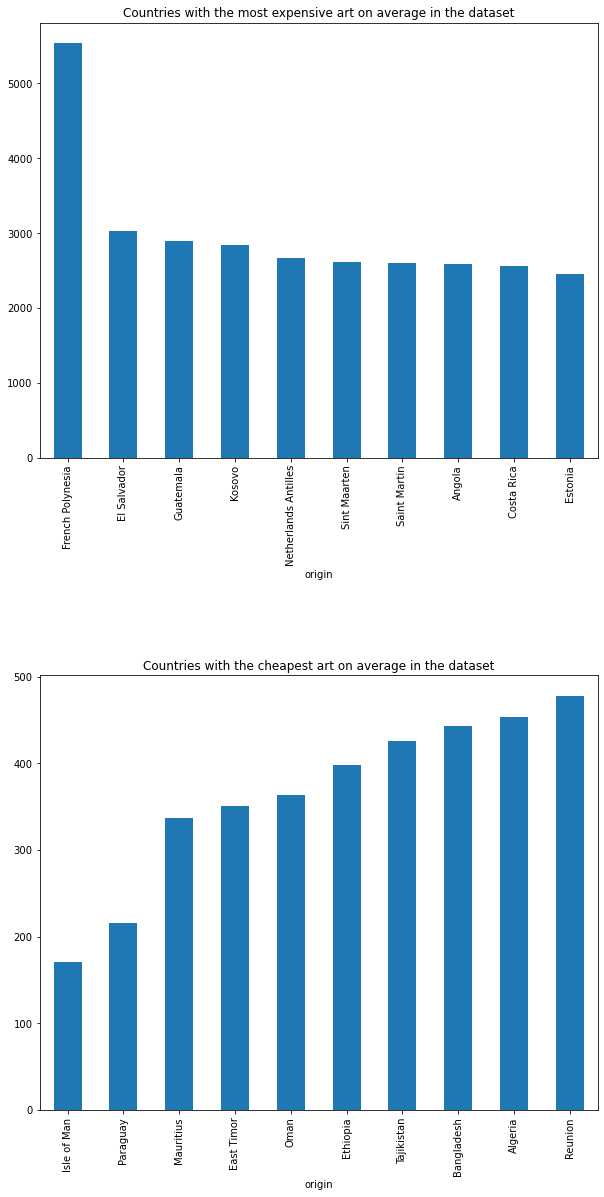

In [30]:
fig, axes = plt.subplots(nrows=2)
fig.set_figheight(20)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=.5)

tabular_data.groupby('origin')['price'].mean().sort_values().nlargest(n=10).plot(
    kind='bar',ax=axes[0], title = "Countries with the most expensive art on average in the dataset")

tabular_data.groupby('origin')['price'].mean().sort_values().nsmallest(n=10).plot(
    kind='bar',ax=axes[1], title = "Countries with the cheapest art on average in the dataset")

In [31]:
print("Number of countries in dataset: " + str(len(tabular_data['origin'].unique())))
print("Number of painters in dataset: " + str(len(tabular_data['painter'].unique())))
print("Number of mediums in dataset: " + str(len(tabular_data['medium'].unique())))

Number of countries in dataset: 142
Number of painters in dataset: 19984
Number of mediums in dataset: 6


<AxesSubplot:title={'center':'Mediums with the most amount of paintings lised in the dataset'}>

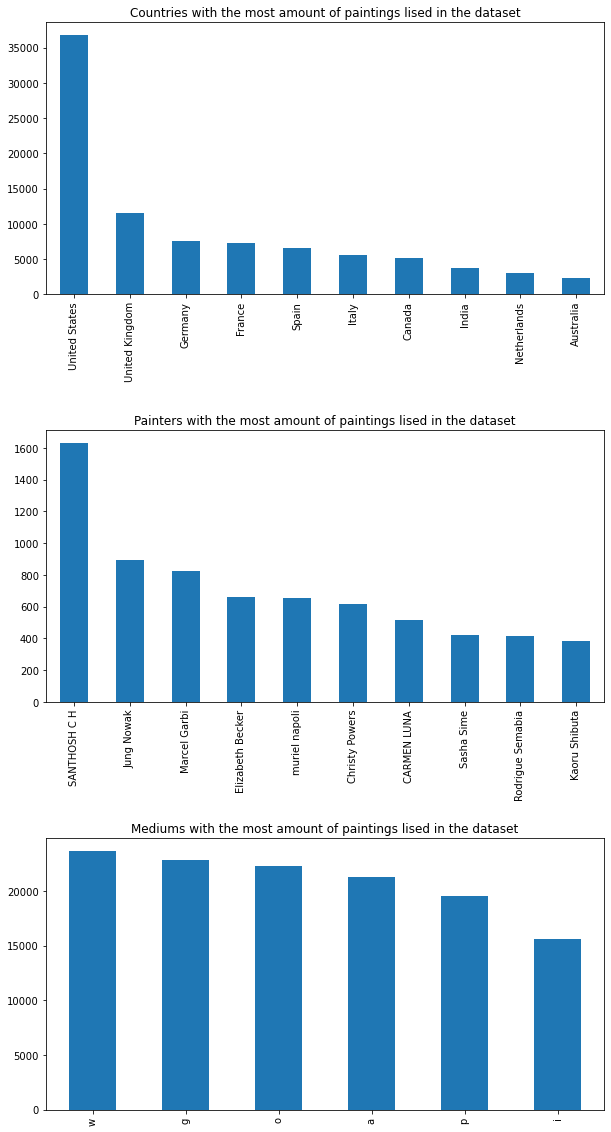

In [32]:
fig, axes = plt.subplots(nrows=3)
fig.set_figheight(20)
fig.set_figwidth(10)
fig.subplots_adjust(hspace=.5)

tabular_data['origin'].value_counts().nlargest(n=10).plot(kind = 'bar',ax=axes[0], title = "Countries with the most amount of paintings lised in the dataset")
tabular_data['painter'].value_counts().nlargest(n=10).plot(kind = 'bar',ax=axes[1], title = "Painters with the most amount of paintings lised in the dataset")
tabular_data['medium'].value_counts().sort_values().nlargest(n=10).plot(kind = 'bar',ax=axes[2], title = "Mediums with the most amount of paintings lised in the dataset")

In [63]:
fig = px.scatter(tabular_data, x="price", y="width", trendline="ols",trendline_color_override="black")
fig.show()

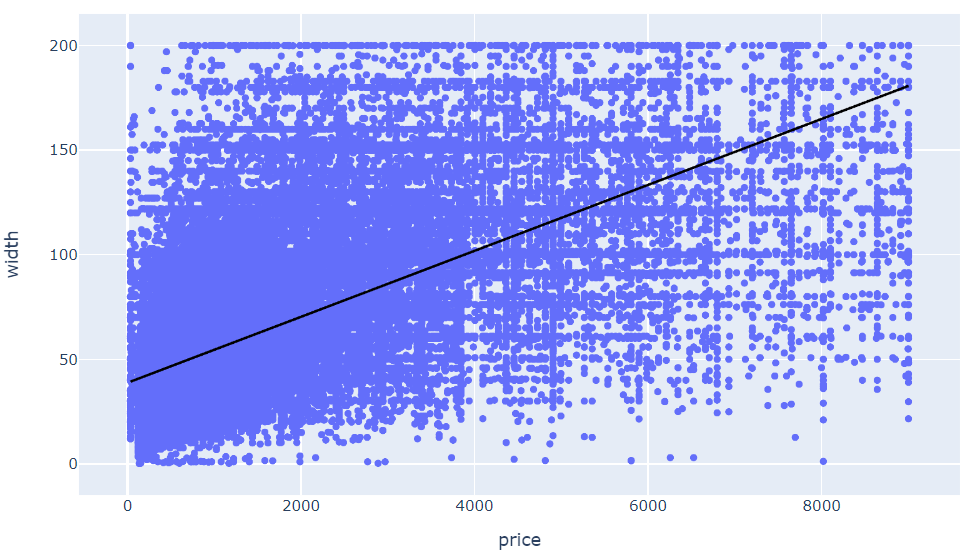

In [66]:
fig = px.scatter(tabular_data, x="price", y="height", trendline="ols",trendline_color_override="black")
fig.show()

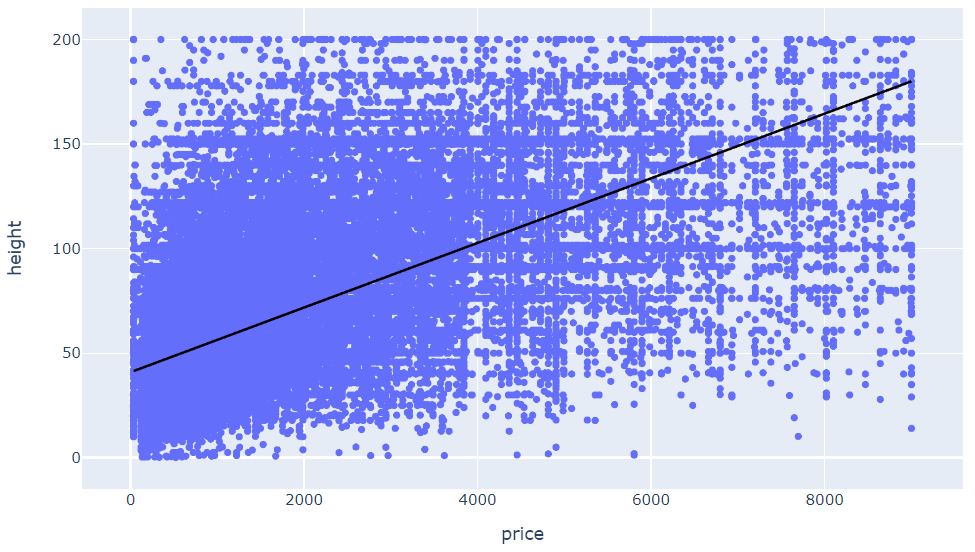

## Encode

In [35]:
# encode "medium" with OneHot

encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(raw_data[['medium']]).toarray())

# merge one-hot encoded columns back with original df
cleaned_data = tabular_data.join(encoder_df)

# delete dimensions and medium columns
del cleaned_data['dimensions']
del cleaned_data['medium']

# rename columns to include medium names instead of numbers
cleaned_data.columns = ['image', 'title', 'painter', 'origin', 'price', 'width', 'height', 'area',\
                   'acrylic', 'guache', 'ink', 'oil', 'pastel', 'watercolour']

In [36]:
# check unique values by column
print(cleaned_data.nunique())

image          111136
title           98222
painter         19984
origin            142
price            2812
width            1104
height           1098
area            10086
acrylic             2
guache              2
ink                 2
oil                 2
pastel              2
watercolour         2
dtype: int64


In [37]:
# remove duplicate images
cleaned_data.drop_duplicates(subset='image', keep='first', inplace=True)
cleaned_data.reset_index(drop = True, inplace = True)

In [38]:
# encode "origin" with frequency encoding

freq_enc = cleaned_data.groupby('origin').size()/len(cleaned_data)
cleaned_data.loc[:, 'origin_freq_encoding'] = cleaned_data['origin'].map(freq_enc)

In [39]:
min_max_scaler = MinMaxScaler()

In [40]:
cleaned_data[['price', 'width', 'height', 'area']] = min_max_scaler.fit_transform(cleaned_data[['price', 'width', 'height', 'area']])

In [41]:
# validate maximum value is 1, minimum is 0
print(cleaned_data['height'].max())
print(cleaned_data['height'].min())

1.0
0.0


In [42]:
# retain to further reduce noise in the dataframe
cleaned_data = cleaned_data.drop(cleaned_data[cleaned_data.origin_freq_encoding < 0.009].index).reset_index(drop = True)

In [43]:
# calculate number of
print("medium: {value: freq, value: freq}") 
print('acrylic: ' + str(dict(cleaned_data['acrylic'].value_counts())))
print('oil: ' + str(dict(cleaned_data['oil'].value_counts())))
print('guache: ' + str(dict(cleaned_data['guache'].value_counts())))
print('ink: ' + str(dict(cleaned_data['ink'].value_counts())))
print('watercolour: ' + str(dict(cleaned_data['watercolour'].value_counts())))
print('pastel: ' + str(dict(cleaned_data['pastel'].value_counts())))

medium: {value: freq, value: freq}
acrylic: {0.0: 76737, 1.0: 14751}
oil: {0.0: 72160, 1.0: 19328}
guache: {0.0: 72482, 1.0: 19006}
ink: {0.0: 80939, 1.0: 10549}
watercolour: {0.0: 80287, 1.0: 11201}
pastel: {0.0: 74835, 1.0: 16653}


## Create cleaned_data

In [44]:
# df slicing to extract a total of 60000 images and ensure an equal distribution between mediums
cleaned_data = cleaned_data.iloc[pd.np.r_[5365:15495, 23225:33356, 40826:50957, 56468:66598, 66599:75946, 81356:91487]]
cleaned_data.reset_index(drop = True, inplace = True)

<ipython-input-44-b5526f78d20c>:2: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [45]:
cleaned_data

,image,title,painter,origin,price,width,height,area,acrylic,guache,ink,oil,pastel,watercolour,origin_freq_encoding
0,2242592-HSC00001-6.jpg,The Road,Pearse Gilmore,France,0.012048,0.096597,0.067034,0.006580,0.0,0.0,0.0,0.0,1.0,0.0,0.056327
1,8229473-MVQKJJJQ-6.jpg,Mirage .IV abstract modern yellow painting,sia aryai,United States,0.308233,0.558559,0.558779,0.312480,0.0,0.0,0.0,0.0,1.0,0.0,0.291229
2,8200891-XILBBUZE-6.jpg,Far Nobler And Braver,Danny Cassese,United States,0.089357,0.253253,0.202601,0.051561,0.0,0.0,0.0,0.0,1.0,0.0,0.291229
3,8171201-ZFYODSPS-6.jpg,Chaga 7,Robert Langley,United States,0.023650,0.456456,0.609305,0.278540,0.0,0.0,0.0,0.0,1.0,0.0,0.291229
4,8089795-ALMEEZKA-6.jpg,Morning at Bharatpur,Nidhi Bhatia,India,0.114458,0.361361,0.266133,0.096472,0.0,0.0,0.0,0.0,1.0,0.0,0.025491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,6734048-HSC00001-6.jpg,Pink Vibes Vol-2,Javier Lampreave,Spain,0.041165,0.139139,0.189595,0.026599,0.0,0.0,0.0,0.0,0.0,1.0,0.053925
59996,6729725-QWAYURNQ-6.jpg,Good year,Anastasia Zakharova,Netherlands,0.095939,0.364364,0.259630,0.094899,0.0,0.0,0.0,0.0,0.0,1.0,0.024385
59997,6723647-HSC00001-6.jpg,young girl 15,Giorgio Gosti,Italy,0.021084,0.174174,0.264632,0.046374,0.0,0.0,0.0,0.0,0.0,1.0,0.045233
59998,6717395-FGMXMGXD-6.jpg,Lucid Dream Duo【楚梦】-Limited Edition Print (A2s...,Jade Li,Australia,0.024989,0.209209,0.296648,0.062369,0.0,0.0,0.0,0.0,0.0,1.0,0.018248


In [46]:
cleaned_data.isna().sum()

image                   0
title                   0
painter                 0
origin                  0
price                   0
width                   0
height                  0
area                    0
acrylic                 0
guache                  0
ink                     0
oil                     0
pastel                  0
watercolour             0
origin_freq_encoding    0
dtype: int64

In [47]:
# save cleaned_data to csv file, "index=False" is used to not include the index in csv file
cleaned_data.to_csv('cleaned_data.csv', index=False)

# Split Dataset into Train, Validation and Test

## Split the dataset
train_test_split from Scikit-Learn were use twice to create train, validation, test dataset with ratio 80:10:10

In [48]:
X = cleaned_data.drop(columns = 'price').copy()
y = cleaned_data['price']

# We split the data in 80:10:10 for train:valid:test dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=42)

# Valid and test size to be equal, set test_size = 0.5 because 0.5 x 0.2 (remaining) equals to 0.1
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

print("Train"), print(X_train.shape), print(y_train.shape)
print("Valid"), print(X_valid.shape), print(y_valid.shape)
print("Test"), print(X_test.shape), print(y_test.shape)

Train
(48000, 14)
(48000,)
Valid
(6000, 14)
(6000,)
Test
(6000, 14)
(6000,)


(None, None, None)

## Sort the split dataset
The target data (price) is used not only with tabular dataset but also image dataset. Since, by default, the image dataset is sorted based on its name, all the dataset should also be sorted based on image name.

In [49]:
# sort X_train & y_train based on 'image'
X_train['price'] = y_train
X_train.sort_values(by='image', ignore_index=True, inplace=True)

y_train = X_train['price']
X_train.drop(columns='price', inplace=True)

In [50]:
# sort X_valid & y_valid based on 'image'
X_valid['price'] = y_valid
X_valid.sort_values(by='image', ignore_index=True, inplace=True)

y_valid = X_valid['price']
X_valid.drop(columns='price', inplace=True)

In [51]:
# sort X_test & y_test based on 'image'
X_test['price'] = y_test
X_test.sort_values(by='image', ignore_index=True, inplace=True)

y_test = X_test['price']
X_test.drop(columns='price', inplace=True)

In [52]:
# save the train, validation, and test dataset into csv
# use "index=False" if you do not want to include the index in the csv file
X_train.to_csv('X_train.csv', index=False)
X_valid.to_csv('X_valid.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_valid.to_csv('y_valid.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Images Dataset

## Load image dataset
Unzip all_images.zip, create split folder, and copy relevant images to split folder based on train, validation, and test dataset

In [151]:
# unzip all_images.zip containing 120895 images (*.jpg)
shutil.unpack_archive('all_images.zip')

In [ ]:
# folder name for split train, validation, and test
folder = 'split_folder'
subfolder = ['train', 'valid', 'test']

# directory for train, validation, and test dataset (images & csv files)
train_f = folder+'/'+subfolder[0]
valid_f = folder+'/'+subfolder[1]
test_f = folder+'/'+subfolder[2]

# create folder and subfolder for train, valid, test
for i in subfolder:
    os.makedirs(folder+'/'+i, exist_ok=True)

In [ ]:
# copy the images according to list of imagename
def copy_images(list_name, destination_folder):
    print('Images transfer to '+destination_folder)
    for filename in tqdm(list_name):
        origin = os.path.join('all_images', filename)
        if os.path.exists(origin):
            shutil.copy(origin, destination_folder)

copy_images(X_train['image'], train_f)
copy_images(X_valid['image'], valid_f)
copy_images(X_test['image'], test_f)

## Preprocess images for VGG16 & VGG19
#### Note: Image preprocessing on validation and test dataset with 6000 images for each dataset can be done with 16 GB RAM, but for train dataset with 48000 images, at least 64 GB RAM is needed
Resize image to 224 x 224, convert to array, and rescale the pixel between 0 and 1

In [ ]:
# Function to transform images
def prepare_image(start, end, list_name, set_path):
    prep_image = []
    for i in tqdm(range(start, end)):
        img = image.load_img(set_path+'/'+list_name[i], target_size=(224,224), color_mode='rgb')
        img = image.img_to_array(img)
        img = img/255
        prep_image.append(img)
    return prep_image

# Function to create array in batches
def batch_process(batch_size, list_name, set_path):
    chunked_list = list(chunked(list_name, batch_size))
    img_set = []
    for i in range(len(chunked_list)):
        print('Batch: ',str(i+1),'/',str(len(chunked_list)))
        try:
            img_ = np.array(prepare_image((i*batch_size), ((i+1)*batch_size), list_name, set_path))
        except KeyError:
            img_ = np.array(prepare_image((i*batch_size), list_name.shape[0], list_name, set_path))
        img_set.extend(img_)
    return img_set

In [ ]:
# create array for all validation images (6000 images)
valid_images = batch_process(512, X_valid['image'], valid_f)

In [ ]:
# create array for all test images (6000 images)
test_images = batch_process(512, X_test['image'], test_f)

### Crosscheck the order between dataset (image & tabular)
Inspect the images and its respective details in tabular data.
Click the link and it must show the same image as what is shown in here

In [ ]:
# 1st image name in validation dataset
print(X_valid['image'][0]) 

# image link from raw_data which consists of 1st image name in validation dataset
for i in raw_data['image']:
    if X_valid['image'][0] in i:
        print(i)
    else:
        pass

# 1st image in valid_images array
plt.imshow(valid_images[0])

In [ ]:
np.save('valid_images.npy', valid_images)
np.save('test_images.npy', test_images)

#### Minimum 64 GB RAM is needed to run the code below:
48000 images x 3 (RGB) x 224 x 224 x float64 = 57.8 GBytes

In [ ]:
# # create array for all train images (48000 images)
# train_images = batch_process(512, X_train['image'], train_f)
# np.save('train_images.npy', train_images)